# Total Energy Expenditure by Mass Scatter Plot

The plot that will be reproduced in this example is a log-log scatter plot of total energy expenditure (kcal/day) against mass (kg) as published by Pontzer et al. (2014) in PNAS (doi: [10.1073/pnas.1316940111](http://dx.doi.org/10.1073/pnas.1316940111)). Log-log plots of this sort are fairly common in biological anthropology, and this one has some of the common complications: multiple fitted lines, confidence intervals, different colored points for different groups, and some annotations.

![](images/energyexpenditure_plot.png)

The data underlying this plot are included in the supplementary material of the paper and have been extracted and made available in my bioanth datasets repository.

## Some preliminaries

First, I always change the R option for importing strings (I find that the default convert to factor causes more problems than it solves).

In [1]:
options(stringsAsFactors=F)

Next, import the data. The resulting data frame has five variables: species, order, captive, mass (in kg), and tee (total energy expenditure in kcal/day).

In [2]:
dset = read.csv(url("https://raw.githubusercontent.com/ryanraaum/bioanth-datasets/master/raw/energyexpenditure.csv"))
str(dset)

'data.frame':	86 obs. of  5 variables:
 $ species: chr  "Microcebus_murinus" "Lepilemur_ruficaudatus" "Eulemur" "Lemur_catta" ...
 $ order  : chr  "Primates" "Primates" "Primates" "Primates" ...
 $ captive: chr  "no" "no" "no" "no" ...
 $ mass   : num  0.064 0.77 1.84 2.24 2.21 4.9 7.12 12 72.2 46.6 ...
 $ tee    : num  28 121 146 146 217 ...


While it is possible to do log transformations on the fly, I find that doing so will lead to complications down the line, so it is best to just create new logged variables in the working data frame.

In [57]:
dset$logmass = log10(dset$mass)
dset$logtee = log10(dset$tee)

Because the target plot shows primates in red and nonprimates in black, it will be useful to have a variable for this color difference. 

In [3]:
point_color = ifelse(dset$order == "Primates", "red", "black")
table(point_color)

point_color
black   red 
   67    19 

In addition, the nonprimates and the non-captive primates have filled circles while the captive primates have non-filled ones, so a variable for this will be useful as well. Because there are missing data in the `captive` variable (unknown/missing for the nonprimates), and we want three different fills (black, red, none), the fill factor has to be constructed a little differently than the simple `ifelse` I used just above for the outline color.

In [34]:
point_fill = rep(adjustcolor("black", alpha=0.5), nrow(dset)) # adjustcolor used to add some transparency
point_fill[dset$captive == "no"] = adjustcolor("red", alpha=0.5)
point_fill[dset$captive == "yes"] = rgb(0,0,0,0) # this makes a fully transparent "fill" color - i.e. no fill
table(point_fill)

point_fill
#00000000 #00000080 #FF000080 
       11        67         8 

The target plot has three different OLS regression lines on it:

1. Nonprimates (black line)
2. Primates (red line)
3. Primates without the mouse lemur (red dashed line)

So these data subsets and regression models will be useful.

In [81]:
nonprimates = subset(dset, order != "Primates")
allprimates = subset(dset, order == "Primates")
subprimates = subset(allprimates, species != "Microcebus_murinus")

nonprimatesfit = lm(logtee ~ logmass, data=nonprimates)
allprimatesfit = lm(logtee ~ logmass, data=allprimates)
subprimatesfit = lm(logtee ~ logmass, data=subprimates)

## Base R

First, set up the plot area. The `expression` function is used to format the subscripts in the axis labels.

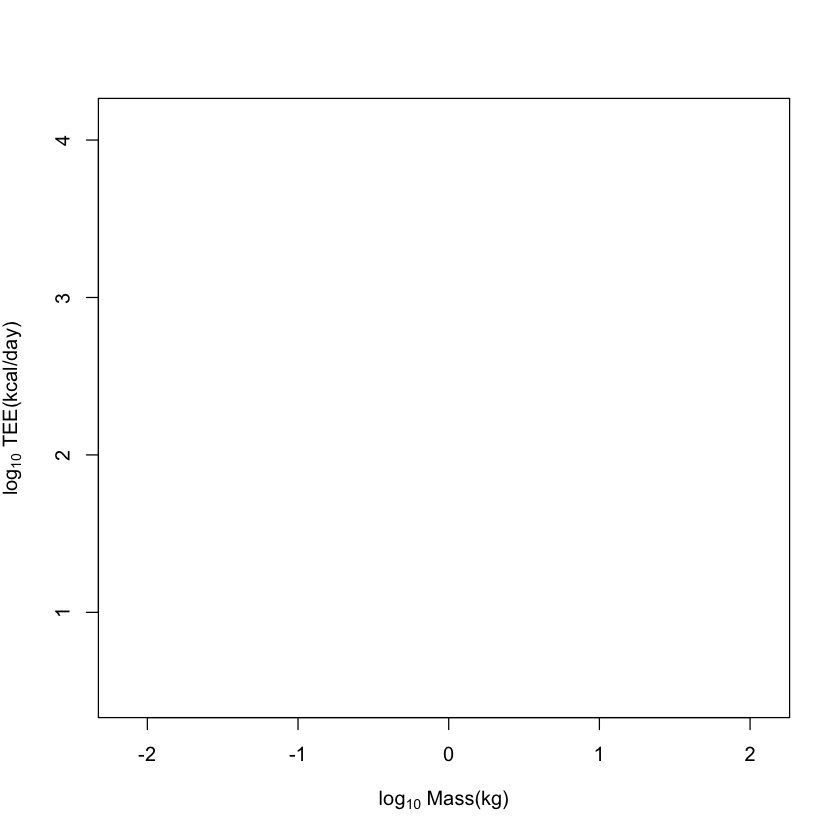

In [93]:
plot(logtee ~ logmass, 
     data=dset, 
     type='n', # 'none' - no points will be plotted
     xlab=expression("log"[10]*" Mass(kg)"),
     ylab=expression("log"[10]*" TEE(kcal/day)"))

The target plot uses a larger font for the axis labels.

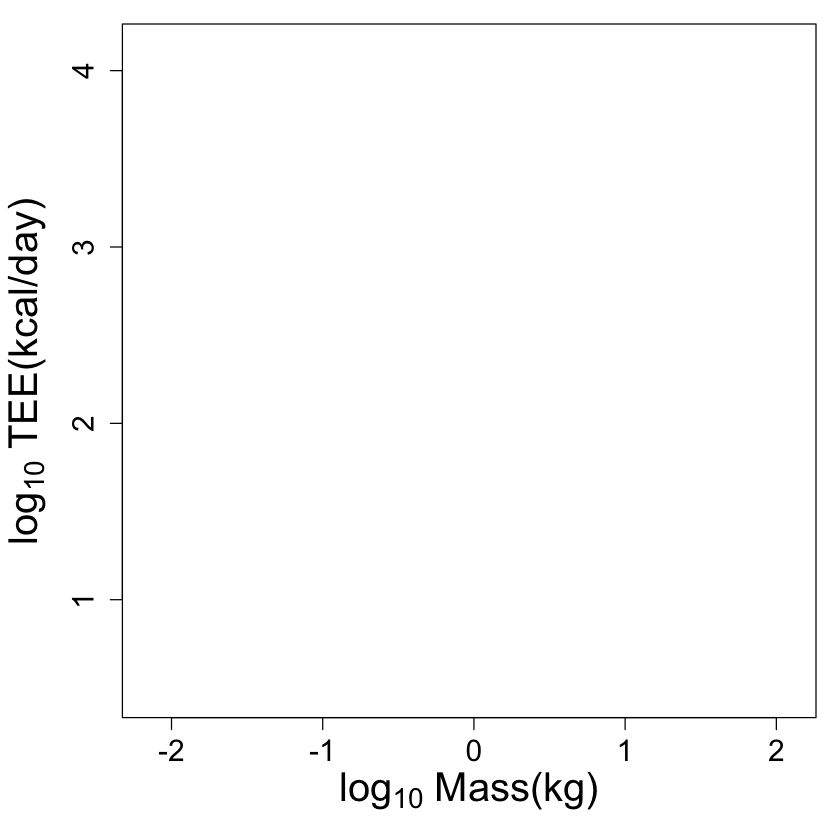

In [97]:
# The par command normally changes the margins of the plot in a semi-permanent way.
# That is, in a normal R session (not the notebook I'm using here), you would need 
# to save the old settings to be able to reset them later using "par(old.par)".
# In this notebook, however, each plot is a new plotting area.
old.par = par(mar=c(5.1,5.1,1.0,1.0))

plot(logtee ~ logmass, 
     data=dset, 
     type='n', # 'none' - no points will be plotted
     xlab=expression("log"[10]*" Mass(kg)"),
     ylab=expression("log"[10]*" TEE(kcal/day)"),
     # the numbers below were arrived at by trial and error
     cex.lab=2,    # double the size of the labels
     cex.axis=1.5) # make the axis number 1.5 times usual size

The points in the target plot are a little complicated because they have a darker outer ring and a slightly less dark fill (for those points that have a fill). To accomplish this, first plot the inner fills with plotting character (`pch`) 16 (a filled circle), then overplot those with plotting character 1 (an open circle).

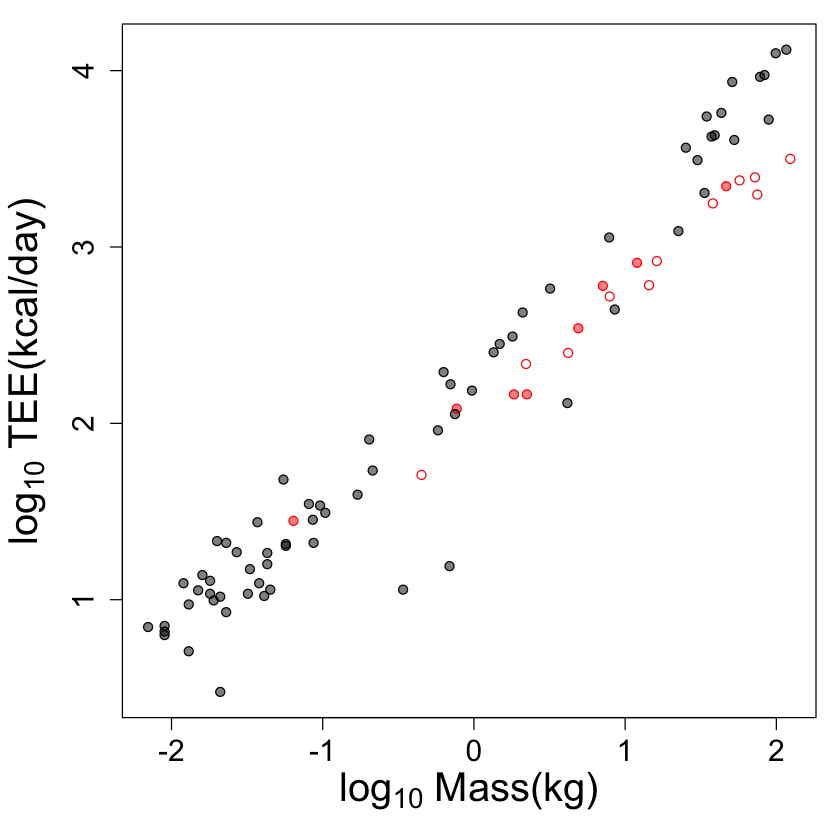

In [98]:
# set up the plot area
par(mar=c(5.1,5.1,1.0,1.0))
plot(logtee ~ logmass, 
     data=dset, 
     type='n',
     xlab=expression("log"[10]*" Mass(kg)"),
     ylab=expression("log"[10]*" TEE(kcal/day)"),
     cex.lab=2,
     cex.axis=1.5)

# first plot filled circles
with(dset, points(logmass, logtee, pch=16, col=point_fill))
# then overplot with open circles
with(dset, points(logmass, logtee, pch=1, col=point_color))

The fitted lines and their confidence intervals are the most complicated part of this plot. The nonprimates line is the easiest because it runs the full width of the plot area, so that is easiest to add. 

Note how the elements are layered onto the plot: confidence interval shading first, then the fitted line, then the points.

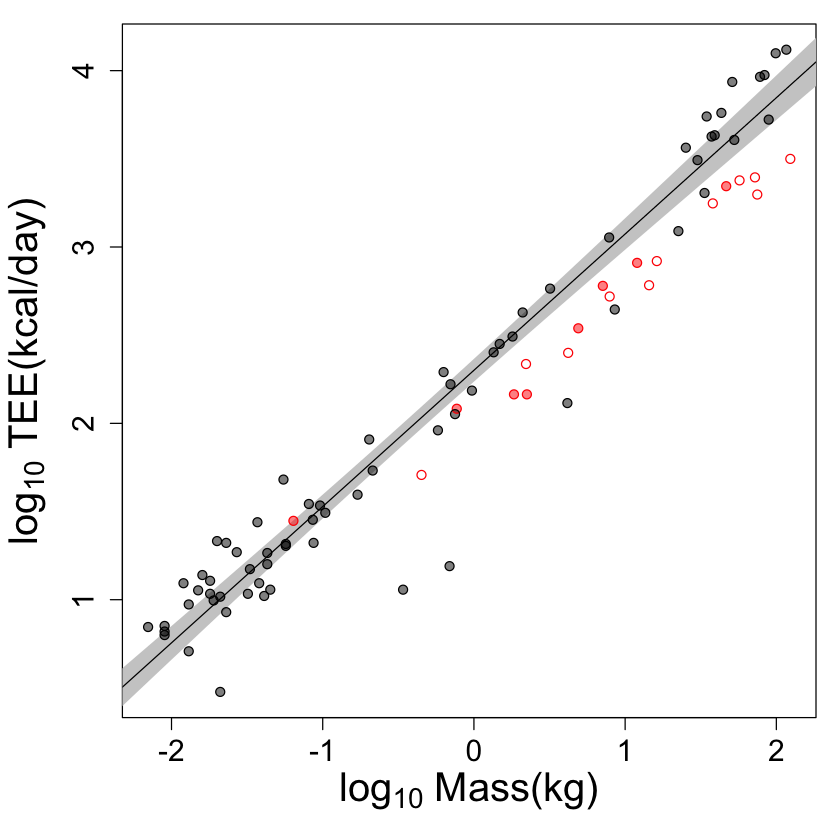

In [100]:
# set up the plot area
par(mar=c(5.1,5.1,1.0,1.0))
plot(log10(tee) ~ log10(mass), 
     data=dset, 
     type='n',
     xlab=expression("log"[10]*" Mass(kg)"),
     ylab=expression("log"[10]*" TEE(kcal/day)"),
     cex.lab=2,
     cex.axis=1.5)

# generate a range of x-axis values (logmasses) to use in generating the confidence interval
np_massrange = seq(-3, 3, length.out=100)
# calculate the point, upper, and lower estimates from the model
np_interval = predict(nonprimatesfit, 
                      newdata=data.frame(logmass=np_massrange), 
                      interval='confidence')
# plot a filled polygon covering the area between the upper and lower limits
polygon(c(rev(np_massrange), np_massrange),           # x values
        c(rev(np_interval[,3]), np_interval[,2]),     # y values
        col='grey80',
        border=NA)
# add the fitted line
abline(nonprimatesfit)

# add the points
with(dset, points(log10(mass), log10(tee), pch=16, col=point_fill))
with(dset, points(log10(mass), log10(tee), pch=1, col=point_color))

Now to add the fitted lines and confidence interval for the primate data.

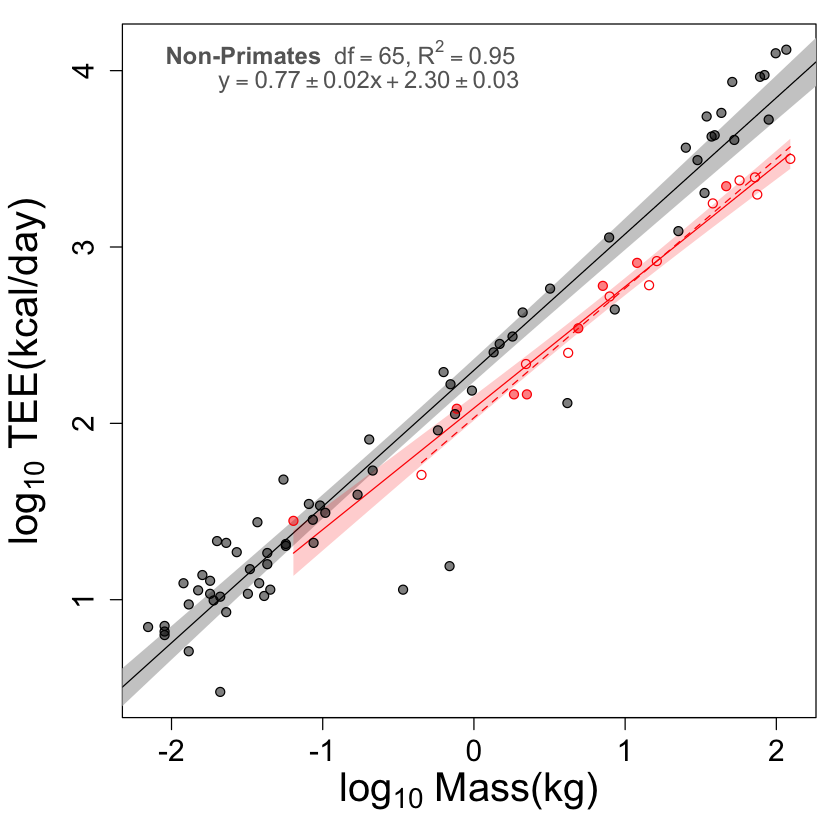

In [139]:
# set up the plot area
par(mar=c(5.1,5.1,1.0,1.0))
plot(log10(tee) ~ log10(mass), 
     data=dset, 
     type='n',
     xlab=expression("log"[10]*" Mass(kg)"),
     ylab=expression("log"[10]*" TEE(kcal/day)"),
     cex.lab=2,
     cex.axis=1.5)

# add nonprimates confidence interval and line
np_massrange = seq(-3, 3, length.out=100)
np_interval = predict(nonprimatesfit, 
                      newdata=data.frame(logmass=np_massrange), 
                      interval='confidence')
polygon(c(rev(np_massrange), np_massrange),           
        c(rev(np_interval[,3]), np_interval[,2]),     
        col='grey80',
        border=NA)
abline(nonprimatesfit)

# add all primates confidence interval and line (pretty much the same as above)
ap_massrange = seq(min(allprimates$logmass), max(allprimates$logmass), length.out=100)
ap_interval = predict(allprimatesfit, 
                      newdata=data.frame(logmass=ap_massrange), 
                      interval='confidence')
polygon(c(rev(ap_massrange), ap_massrange),           
        c(rev(ap_interval[,3]), ap_interval[,2]),     
        col=adjustcolor("red", alpha=.2),
        border=NA)
lines(c(min(ap_massrange), max(ap_massrange)),                  
      c(ap_interval[1,1], ap_interval[length(ap_massrange),1]), 
      col="red")

# add the primates without mouse lemur fitted line
sb_minmax = c(min(subprimates$logmass), max(subprimates$logmass))
sb_fitted = predict(subprimatesfit,
                      newdata=data.frame(logmass=sb_minmax))
lines(sb_minmax,      # x values for ends of line
      sb_fitted,  # y values for ends of line
      col="red",
      lty=2)

# add the points
with(dset, points(log10(mass), log10(tee), pch=16, col=point_fill))
with(dset, points(log10(mass), log10(tee), pch=1, col=point_color))

# add the annotations
np_df = nonprimatesfit$df.residual
np_r2 = format(round(summary(nonprimatesfit)$r.squared, 2), nsmall=2)
np_b0 = format(round(nonprimatesfit$coefficients[1], 2), nsmall=2)
np_b1 = format(round(nonprimatesfit$coefficients[2], 2), nsmall=2)
np_e0 = format(round(summary(nonprimatesfit)$coefficients[1,2], 2), nsmall=2)
np_e1 = format(round(summary(nonprimatesfit)$coefficients[2,2], 2), nsmall=2)
legend('topleft', bty='n', pch=NA, text.col='grey40', cex=1.2,
       legend=c(as.expression(bquote(bold('Non-Primates ') ~ df == .(np_df) * ',' ~ R^2 == .(np_r2))),
                as.expression(bquote('       ' ~ y == .(np_b1)%+-%.(np_e1)*x + .(np_b0)%+-%.(np_e0)))))